# Livrable 1 - groupe 1

Nous sommes le groupe 1 composé de :  
- DELORME Alexandre
- ENCOGNERE Yanis
- MENNERON Laurine
- PEREON Alexandre
- ROCHARD Léo

## Contenu du livrable
Dans ce premier livrable, nous allons nous intéresser à la classification multiclasses de nos données. 
Nous avons à disposition : des peintures, des schémas/graphes, des portraits dessinés en noir et blanc, des images de textes scannés et des photos.  
Nous réaliserons dans un premier temps une analyse exploratoire des données (`EDA`) afin de mieux comprendre les caractéristiques de notre jeu de données, d’identifier d’éventuelles anomalies ou déséquilibres, et de préparer les données pour l’entraînement. Cette étape inclura notamment une visualisation des classes, la vérification des tailles et des formats d’images, ainsi que des traitements éventuels (redimensionnement, normalisation, data augmentation).  
Nous allons ensuite définir `l’architecture de notre modèle de classification d’images`. Nous justifierons les choix réalisés concernant la structure de notre réseau ainsi que les choix des `hyperparamètres` de nos différentes couches (nombre de filtres, taille des noyaux de convolution, fonctions d’activation, couches de pooling, etc.) et les paramètres d'entraînement (learning rate, batch size, nombre d’époques, fonction de perte, optimiseur, etc.).  
Nous entraînerons notre modèle en suivant une démarche itérative : 

__Entraînement :__  
Nous procéderons à l’entraînement du modèle sur notre jeu de données d’apprentissage en intégrant des `techniques de régularisation` (dropout, batch normalization, augmentation de données) pour limiter le sur-apprentissage. 

__Benchmark :__  
Nous mettrons en place un benchmark afin de comparer les performances de différentes architectures ou configurations de notre modèle. Nous testerons plusieurs variantes pour évaluer les impacts sur les performances. 

__Métriques :__  
Les performances du modèle seront évaluées à l’aide de plusieurs `métriques` : accuracy, matrice de confusion, précision, rappel et F1-score. Nous suivrons également la progression de la courbe d’apprentissage pour identifier les cas de sur et de sous-apprentissage. 

__Conclusion :__  
Enfin, nous conclurons ce livrable en récapitulant les résultats obtenus, les points forts et les limites de notre approche actuelle. Nous proposerons également des pistes d’amélioration possibles que nous pourrons appliquer pour les prochains livrables.

## Chargement des bibliothèques

Voici les bibliothèques principales que nous avons utilisées pour ce projet :  
- __NumPy :__ facilite et améliore la manipulation et le `traitement des données`
- __TensorFlow :__ bibliothèque principale de Deep Learning utilisée pour construire, entraîner et évaluer nos modèles de `classification`. Elle fournit des structures de données adaptées, des couches prédéfinies ainsi que les outils nécessaires pour la création de `réseaux de neurones` et leur entraînement
- __VisualKeras :__ outil permettant de générer des représentations graphiques de l’architecture de nos modèles Keras, facilitant ainsi leur visualisation et leur compréhension
- __Scikit-learn (sklearn) :__ utiliser pour `visualiser` et évaluer notre modèle. Utile également pour la réalisation de l’analyse `ACP` et `TSME`
- __Matplotlib et Seaborn :__ utilisation pour la visualisation de nos différents résultats sous forme de `graphiques`

In [1]:
%load_ext tensorboard
import os
import pathlib
import zipfile
from datetime import datetime
from collections import defaultdict

import gdown
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import visualkeras
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

## Sélection de la source de données


Cette partie permet de récuperer le dataset depuis le drive afin d'automatiser la `pipeline`.  
L'objectif est d'utiliser un dataset commun au sein du groupe. 

Ce dernier à le dossier `Sketch` complété par des données trouvés dans les sources suivantes : [croquis](https://paperswithcode.com/dataset/sketch) || [visages réalistes](https://www.kaggle.com/datasets/arbazkhan971/cuhk-face-sketch-database-cufs/data)

Ce qui fait passer le dossier sketch de `606 visages` et `800 croquis` avec un ration de `43%`/`57%` entre visages/croquis à `1200 visages` et `3200 croquis` pour un ratio final équivalent.

In [2]:
# ID du fichier (extrait de l'URL)
file_id = "1d0k3mXd93JM0fLLYrUZRr4Un1F_TnuHi"
dataset_path = "dataset_livrable_1"
zip_path = dataset_path + ".zip"
extract_dir = pathlib.Path(zip_path).parent / dataset_path
reduce_dataset = True

if not os.path.exists(extract_dir):
    print(f"Le dossier '{extract_dir}' n'existe pas. Téléchargement en cours...")
    gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

    print(f"Extraction ZIP en cours...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extraction Zip terminée")
else:
    print(f"Le dossier '{extract_dir}' existe déjà. Téléchargement et extraction non nécessaires.")

data_dir = extract_dir
print(f"Dataset disponible dans : {data_dir}")

Le dossier 'dataset_livrable_1' existe déjà. Téléchargement et extraction non nécessaires.
Dataset disponible dans : dataset_livrable_1


## Détection des catégories

Voici ci-contre la liste des classes de notre dataset :

In [3]:
categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print(f"Catégories détectées : {categories}")

Catégories détectées : ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


## Pré traitement des images

Certaines images de notre dataset sont `corrompues` ou ne sont pas au bon format (exemple avec un fichier « .ini »). Nous devons donc nous assurer de filtrer ces données avant de créer notre dataset. 

In [4]:
# Suppresion des fichiers corrompus ou non images
def clean_images_dataset(dataset_path_arg):
    """
    Fonction pour nettoyer le dataset en supprimant les fichiers corrompus ou non images.
    """
    # Dictionnaire pour stocker le nombre d'images corrompues par classe
    corrupted_count_by_class = defaultdict(int)
    dataset_path = dataset_path_arg
    print("Début de la vérification des images ...")

    # Récupération de toutes les images pour calculer la progression
    all_files = []
    for dir_name in os.listdir(dataset_path):
        dir_path = os.path.join(dataset_path, dir_name)
        for file_name in os.listdir(dir_path):
            all_files.append((dir_name, dir_path, file_name))

    total_files = len(all_files)
    checked_files = 0  # Pour la progression

    # Parcours des images avec affichage de la progression
    for dir_name, dir_path, file_name in all_files:
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            try:
                with open(os.path.join(dir_path, file_name), 'rb') as file:
                    img_bytes = file.read()  # Lire les bytes de l'image
                    img = tf.image.decode_image(img_bytes)  # Essayer de décoder l'image
            except Exception as e:
                corrupted_count_by_class[dir_name] += 1
                print(f"\nImage corrompue : {file_name} dans {dir_name}. Exception: {e}")
                os.remove(os.path.join(dir_path, file_name))
                print(f"Image {file_name} supprimée.")
        else:
            corrupted_count_by_class[dir_name] += 1
            print(f"\nLe fichier {file_name} dans {dir_name} n'est pas une image.")
            os.remove(os.path.join(dir_path, file_name))
            print(f"Fichier {file_name} supprimé.")

        # Mise à jour de la progression
        checked_files += 1
        progress = (checked_files / total_files) * 100
        print(f"\rProgression : [{int(progress)}%] {checked_files}/{total_files} images vérifiées", end="")

    print("\nVérification des fichiers terminée.")

    # Affichage du nombre d'images corrompues par dossier
    for dir_name, count in corrupted_count_by_class.items():
        print(f"Dossier {dir_name} : {count} images corrompues")

    # Nombre total d'images corrompues
    total_corrupted = sum(corrupted_count_by_class.values())
    print(f"Nombre total d'images corrompues ou non image : {total_corrupted}")

## Calcul du nombre de données par classe

Nous comptons ensuite le nombre d’images par dossier pour pouvoir déterminer la `répartition des données par classe`.  
Nous observons que la classe Sketch est très largement `sous représentés` avec seulement `4394` données contre une moyenne de `9998` pour les autres classes.  
Pour pouvoir compenser ce déséquilibre, nous comptons sur la `loss pondération`. Ainsi, notre modèle se trouvera d’autant plus pénalisé si il effectue une mauvaise prédiction sur une image de classe Sketch.  
Nous avons également pensé à générer de nouvelles données à partir de `modèles génératifs` tel qu’un `GAN` et un `auto-encodeur de type VAE`. Cependant, les résultats que nous avons obtenus n’étant pas suffisamment satisfaisants, nous avons décidé de garder uniquement la loss pondération. 

In [5]:
class_counts = {class_name: len(list((data_dir / class_name).glob('*'))) for class_name in categories}
class_counts['Sketch'] = len(list((data_dir / 'Sketch' / 'jpg').glob('*'))) + len(
    list((data_dir / 'Sketch' / 'png').glob('*')))
print(class_counts)

{'Painting': 9999, 'Photo': 9993, 'Schematics': 10000, 'Sketch': 4394, 'Text': 10000}


## Création du dataset

Nous pouvons finalement créer notre dataset à partir des images que nous avons traités précédemment. Nous avons défini un `batch de 32`, un batch élevé nous permet de gagner en performance lors de l'entraînement  au détriment de la mémoire, cette valeur est un bon compromis. Nous avons séparé nos données en 2 ensembles : `80%` pour l’entraînement et `20%` pour la validation.

In [7]:
validation_split = 0.2
seed = 42
batch_size = 32
img_height = 180
img_width = 180

train_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=categories)

val_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=categories)

class_names = train_set.class_names
num_classes = len(class_names)

print(f"Classes found: {class_names}")

Found 44386 files belonging to 5 classes.
Using 35509 files for training.
Found 44386 files belonging to 5 classes.
Using 8877 files for validation.
Classes found: ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


## Visualisation des différentes classes

Voici un échantillon d'images de notre dataset pour les différentes classes :

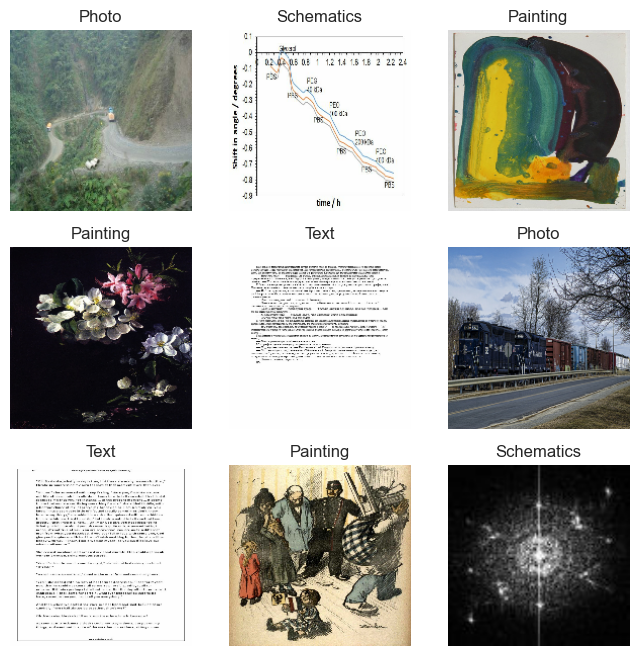

In [8]:
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Répartition des classes au sein du dataset

Le graphique ci-dessous représente la `répartition des données` pour nos datasets `d'entraînement` et de `validation` :

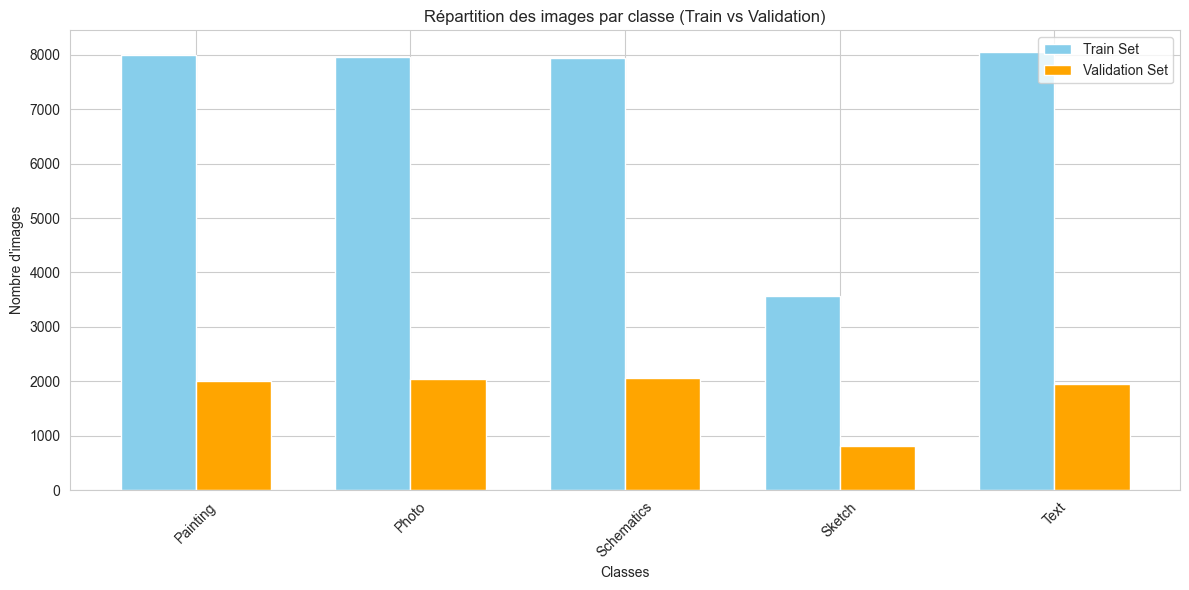

In [9]:
# Compter les échantillons par classe dans train et val
def count_per_class(dataset, class_names):
    class_counts = defaultdict(int)
    for images, labels in dataset:
        for label in labels.numpy():
            class_counts[class_names[label]] += 1
    return class_counts

train_label_counts = count_per_class(train_set, class_names)
val_label_counts = count_per_class(val_set, class_names)

# S'assurer que toutes les classes sont présentes dans les deux sets
classes = class_names
train_counts = [train_label_counts.get(cls, 0) for cls in classes]
val_counts = [val_label_counts.get(cls, 0) for cls in classes]

x = np.arange(len(classes))  # position des classes

# Création du barplot
plt.figure(figsize=(12, 6))
bar_width = 0.35
plt.bar(x - bar_width/2, train_counts, width=bar_width, label='Train Set', color='skyblue')
plt.bar(x + bar_width/2, val_counts, width=bar_width, label='Validation Set', color='orange')

# Mise en forme
plt.xticks(x, classes, rotation=45)
plt.xlabel("Classes")
plt.ylabel("Nombre d'images")
plt.title("Répartition des images par classe (Train vs Validation)")
plt.legend()
plt.tight_layout()
plt.show()

## Analyse

### Préparation pour analyse


Avant d’appliquer les méthodes d’analyse dimensionnelle (`PCA`, `t-SNE`), un sous-ensemble des données d'entraînement a été sélectionné. Pour cela, `20%` des premiers lots d’images ont été extraits afin de réduire le volume de données tout en conservant une représentativité suffisante. Ces images et leurs étiquettes ont ensuite été converties dans un format adapté à l’analyse.

In [10]:
# Prendre 20% des batches du train_set
sampled_batches = list(train_set)[:int(len(train_set) * 0.20)]

# Convertir les images et labels en arrays
images, labels = zip(*[
    (image_batch.numpy(), label_batch.numpy())
    for image_batch, label_batch in sampled_batches
])
images = np.concatenate(images)
labels = np.concatenate(labels)

### Analyse en composantes principales


Nous avons ensuite réalisée une analyse en composantes principales (`PCA`) sur nos données pour réduire la dimensionnalité tout en conservant l’essentiel de l'information. Les résultats des deux premières composantes principales ont été affichés sous forme d'un `graphique 2D`, permettant de visualiser la répartition générale des données sur ces deux axes principaux.

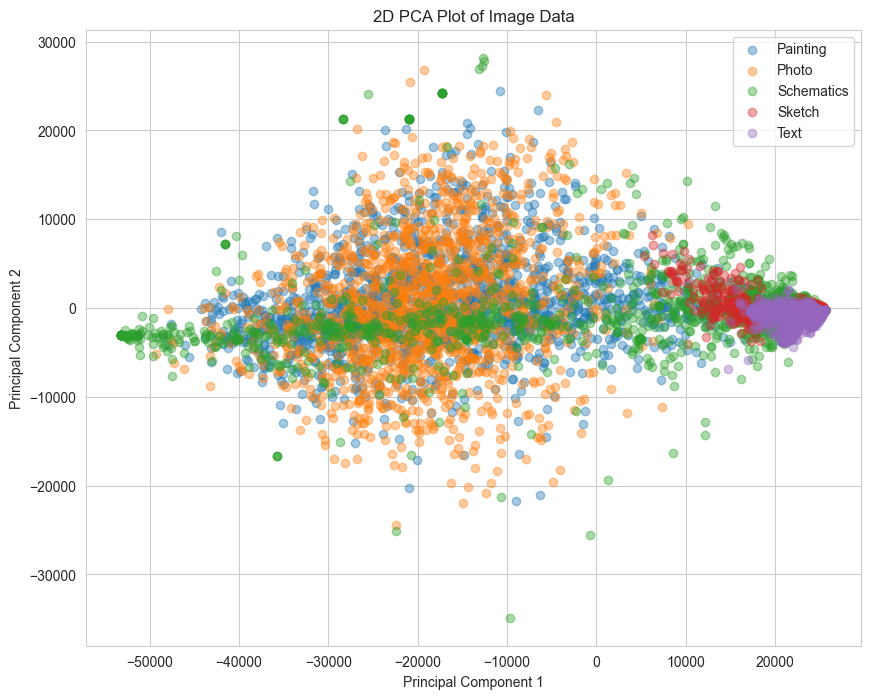

In [11]:
# Réduction dimensionnelle avec PCA
images_reshaped = images.reshape(images.shape[0], -1)
pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(images_reshaped)

# Affichage PCA
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.scatter(pca_result[labels == i, 0], pca_result[labels == i, 1], label=class_names[i], alpha=0.4)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA Plot of Image Data")
plt.legend()
plt.show()

Ensuite, un graphique similaire a été généré pour chaque classe. Chaque graphique présente les points de données de la classe projetés sur les deux premières composantes principales. Cette approche permet de mieux observer la séparation ou les regroupements spécifiques à chaque catégorie d'images, en affichant un sous-graphe distinct pour chaque classe.

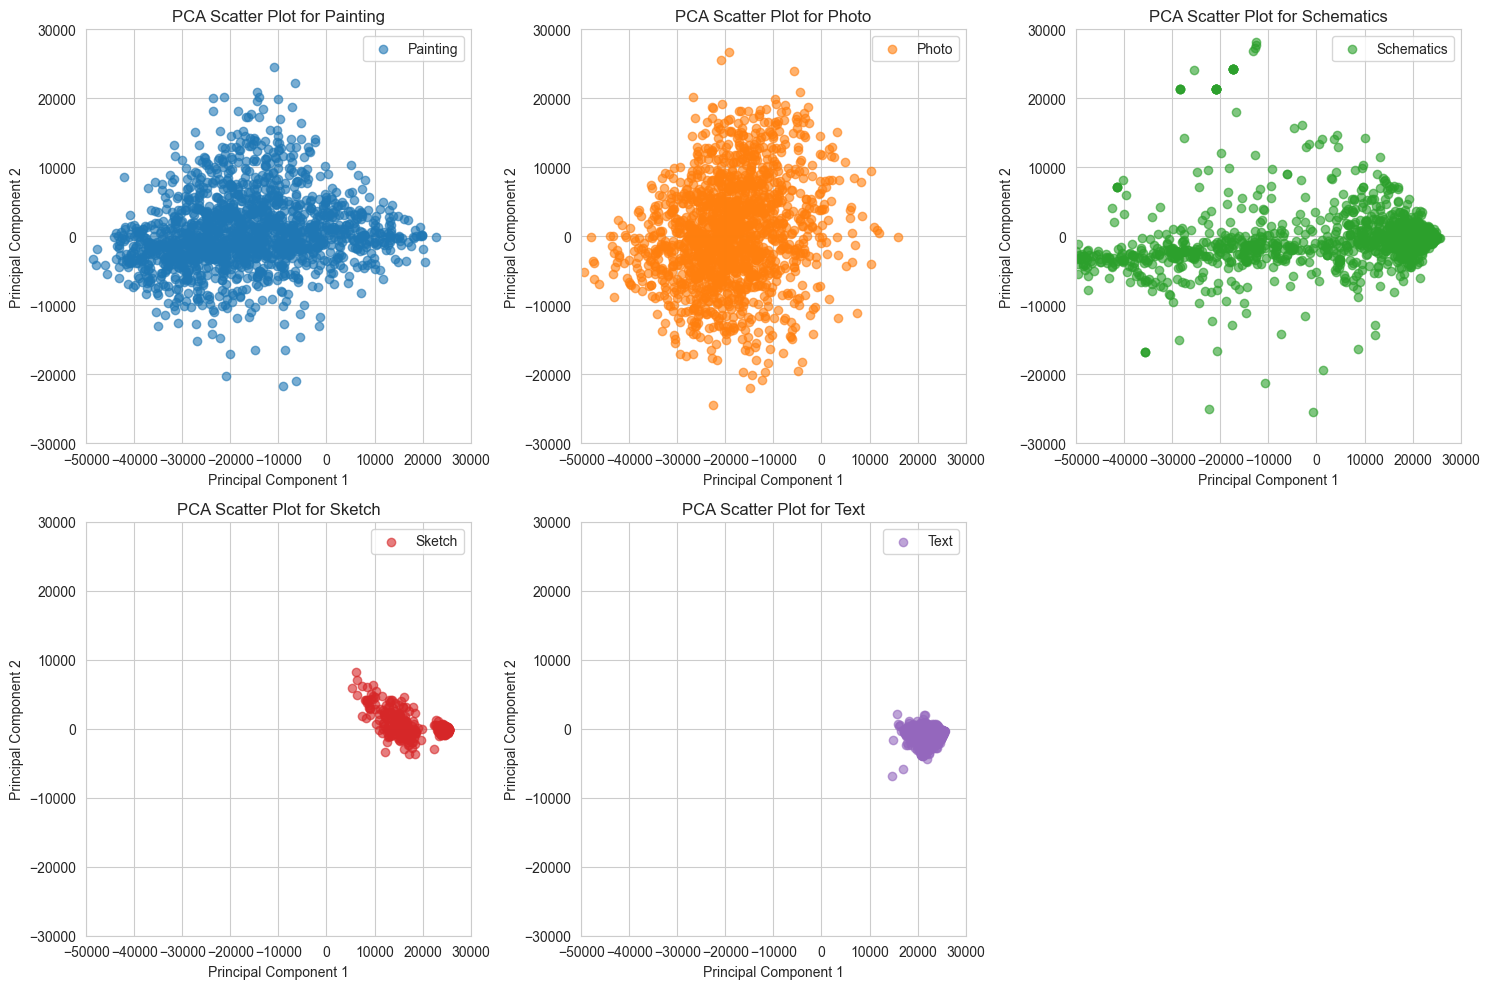

In [12]:
x_min = np.round(pca_result[:, 0].min(), -4)
x_max = np.round(pca_result[:, 0].max(), -4)
y_min = np.round(pca_result[:, 1].min(), -4)
y_max = np.round(pca_result[:, 1].max(), -4)

# Créer des subplots avec 2 lignes et 3 colonnes (ajuster en fonction du nombre de classes)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()  # Aplatir la matrice d'axes pour un accès facile

# Affichage de PCA pour chaque classe dans un subplot distinct
for i in range(len(class_names)):
    ax = axes[i]  # Sélectionner l'axe pour la classe i

    # Filtrer les points de la classe i
    ax.scatter(pca_result[labels == i, 0], pca_result[labels == i, 1],
               alpha=0.6, label=f"{class_names[i]}", color=f"C{i}")

    # Définir les mêmes limites globales pour tous les subplots
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_title(f"PCA Scatter Plot for {class_names[i]}")
    ax.legend()

# Supprimer les axes inutilisés si le nombre de classes est inférieur au nombre de subplots
for j in range(len(class_names), len(axes)):
    fig.delaxes(axes[j])

# Ajuster l'espace entre les subplots pour éviter le chevauchement
plt.tight_layout()
plt.show()

### Interprétation des résultats

L'analyse PCA révèle des distributions variées qui mettent en lumière les défis pour le modèle.

Les peintures et photos sont assez superposées, ce qui rendra leur catégorisation plus complexe en raison de leurs caractéristiques visuelles similaires. Les schémas présentent une distribution linéaire, facilitant leur classification, tandis que les croquis forment un groupe distinct, ce qui aide à les différencier.

Les images de texte sont fortement regroupées, ce qui devrait rendre leur classification relativement simple, mais cela peut devenir problématique si elles sont mélangées avec des catégories plus variées.

### Analyse TSNE


Nous avons réalisé une analyse en parallèle avec `t-SNE` pour réduire la dimensionnalité de nos données, en complément de l'analyse PCA. Cette méthode permet de `projeter les données` dans un espace à `deux dimensions` et d'observer la répartition des différentes catégories d'images dans cet espace réduit, offrant ainsi une perspective complémentaire à celle fournie par le PCA.

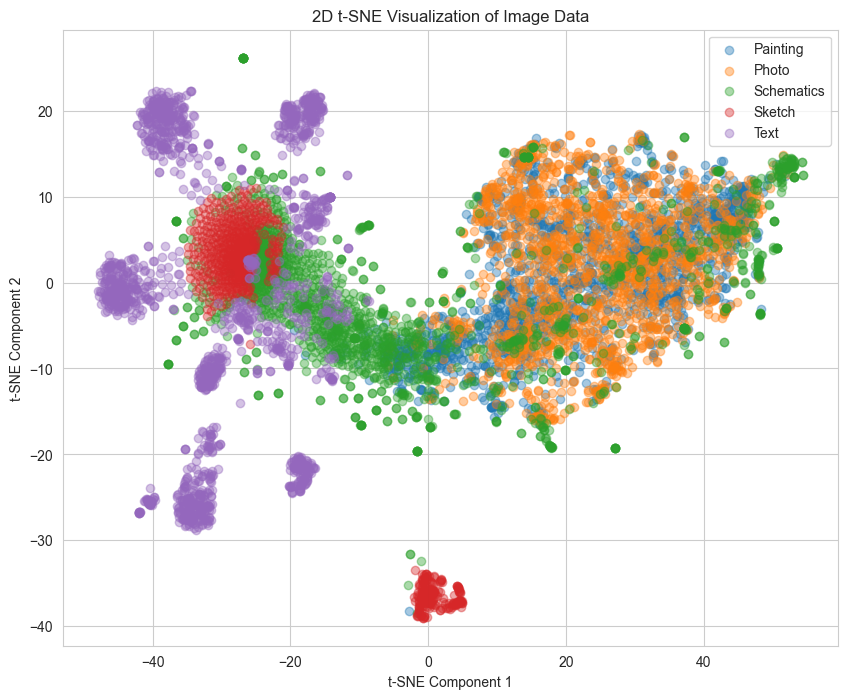

In [13]:
# Réduction dimensionnelle avec t-SNE
tsne = TSNE(n_components=2, random_state=123)
tsne_result = tsne.fit_transform(images_reshaped)

# Affichage t-SNE
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(labels))):
    plt.scatter(tsne_result[labels == i, 0], tsne_result[labels == i, 1], label=f"{class_names[i]}",
                alpha=0.4)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("2D t-SNE Visualization of Image Data")
plt.legend()
plt.show()

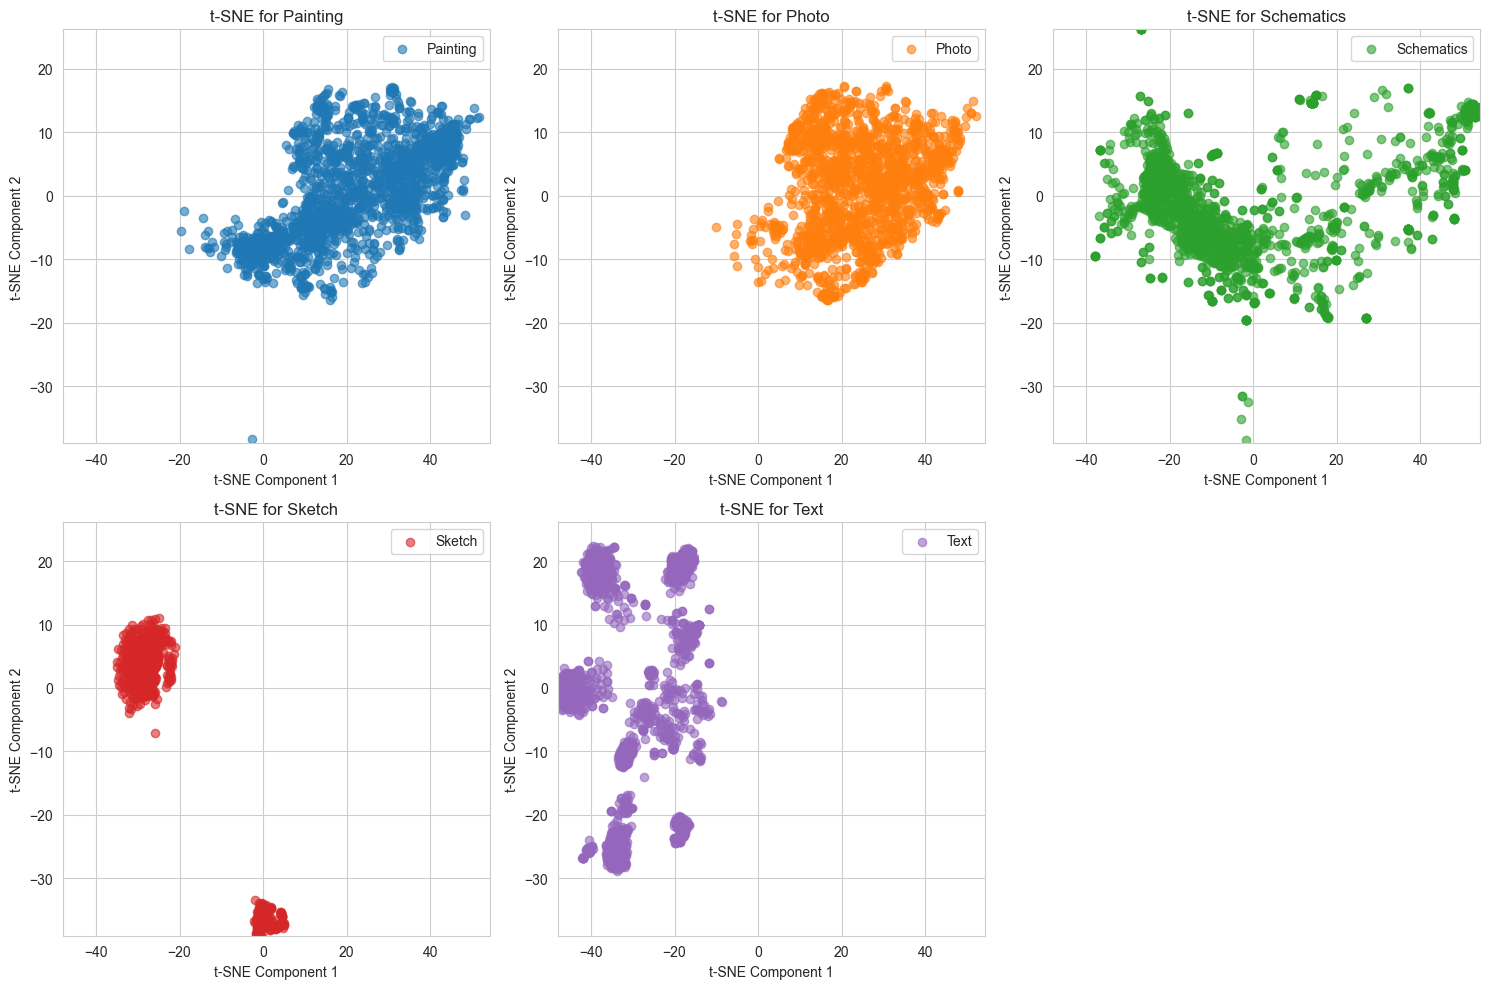

In [14]:
# Déterminer les limites globales des axes pour t-SNE
x_min, x_max = tsne_result[:, 0].min(), tsne_result[:, 0].max()
y_min, y_max = tsne_result[:, 1].min(), tsne_result[:, 1].max()

# Créer des subplots avec 2 lignes et 3 colonnes (tu peux ajuster en fonction du nombre de classes)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()  # Aplatir pour faciliter l'accès aux axes

# Nombre de classes
num_classes = len(np.unique(labels))

# Affichage de t-SNE pour chaque classe dans un subplot distinct
for i in range(num_classes):
    ax = axes[i]  # Sélectionner l'axe pour la classe i

    # Filtrer les points de la classe i
    ax.scatter(tsne_result[labels == i, 0], tsne_result[labels == i, 1],
               alpha=0.6, label=f"{class_names[i]}", color=f"C{i}")

    # Définir les mêmes limites globales pour tous les subplots
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    ax.set_title(f"t-SNE for {class_names[i]}")
    ax.legend()

# Supprimer les axes inutilisés si le nombre de classes est inférieur au nombre de subplots
for j in range(num_classes, len(axes)):
    fig.delaxes(axes[j])

# Ajuster l'espace entre les subplots pour éviter le chevauchement
plt.tight_layout()
plt.show()

### Interprétation des résultats
Les Painting et Photo sont très imbriquées, ce qui pourrait rendre leur séparation difficile pour un modèle, car leurs caractéristiques visuelles sont proches. Les Schematics, bien que plus dispersées, se chevauchent partiellement avec les autres catégories, ce qui indique que le modèle pourrait avoir du mal à les distinguer des Photos ou Peintures.

Les Sketches sont bien séparées, ce qui facilitera leur classification, tandis que les Textes forment des groupes distincts, permettant au modèle de les différencier facilement. En résumé, un modèle d'apprentissage pourrait rencontrer des difficultés pour classifier correctement les Peintures et Photos, mais serait plus performant sur les Croquis et Textes, qui sont mieux séparés.

## Modélisation

### Optimisation pour l'entrainement

Dans cette partie, vous devrez utiliser les fonctions [`Dataset.cache`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) et [`Dataset.prefetch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) afin de configurer les données pour améliorer les performances de la façon suivante :
- `Dataset.cache()` : cette fonction sert à forcer le maintien des données en cache dans la mémoire. Vu que le réseau de neurones fait plusieurs passes (qu'on nomme _époque_ ou _epoch_ en anglais) sur les données durant l'apprentissage, cette fonction permet de ne pas avoir à recharger les images à chaque fois. 
- `Dataset.prefetch()` : cette fonction permet de faire le prétraitement de l'élément courant du jeu de données (par exemple le batch suivant) en même temps que l'entraînement/évaluation du batch courant par le modèle. Dans un environnement multi-processeurs ou multi-cœur, c'est un gain de temps non-négligeable.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Cette commande n'est pas nécessaire sur colab
train_set = train_set.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_set = val_set.prefetch(buffer_size=AUTOTUNE)

### Définition de la fonction de perte

Nous utilisons une `fonction de perte` adaptée à notre problème de classification multiclasses. Cette fonction permet de calculer l’erreur entre les prédictions du modèle et les valeurs réelles afin d’`ajuster les poids` du réseau lors de l’entraînement. 
Afin de limiter l’impact du déséquilibre des classes dans nos données, nous avons défini des poids spécifiques pour chaque classe (`class weights`), attribuant un poids plus élevé aux classes sous-représentées afin de `compenser` leur faible occurrence. 

In [16]:
total = sum(class_counts.values())
weights = {class_name: (total / class_count) for class_name, class_count in class_counts.items()}

max_weight = max(weights.values())
class_weights = {class_name: weight / max_weight for class_name, weight in weights.items()}

print("Class Weights:", class_weights)

# Appliquer les poids dans la fonction de perte
class_weight_tensor = tf.constant([class_weights[class_name] for class_name in categories], dtype=tf.float32)

print("Class_weight_tensor:", class_weight_tensor)


@tf.keras.utils.register_keras_serializable()
def weighted_loss(y_true, y_pred):
    weights = tf.gather(class_weight_tensor, tf.cast(y_true, tf.int32))
    unweighted_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return unweighted_loss * weights

Class Weights: {'Painting': 0.4394439443944394, 'Photo': 0.4397077954568198, 'Schematics': 0.4394, 'Sketch': 1.0, 'Text': 0.4394}
Class_weight_tensor: tf.Tensor([0.43944395 0.4397078  0.4394     1.         0.4394    ], shape=(5,), dtype=float32)


### Définition du modèle

#### Architecture
Nous avons construit un `réseau de neurones convolutionnels` (CNN), architecture particulièrement adaptée au traitement et à la `classification d’images`.  
Notre modèle suit une structure classique composée de plusieurs `couches` successives :  
- Couches de convolution : extraction des caractéristiques locales des images à l’aide de `filtres convolutionnels`
- Couches de pooling : `réduction de la dimensionnalité` et des paramètres, limitation du risque de sur-apprentissage
- Couches finales : `flatten pour vectoriser les données`, suivi de couches Dense pour la prise de décision. La dernière
- Couche Dense : utilise une `activation softmax` adaptée à la classification multiclasse

#### Techniques complémentaires
- Application de `Dropout` après certaines couches pour `limiter le sur-apprentissage` (overfitting) en désactivant aléatoirement des neurones lors de l’entraînement
- Choix du `nombre de couches`, du `nombre de neurones` et des `hyperparamètres` (kernel size, filtres, taux de dropout, etc.) basé sur :  
    * Nos recherches personnelles et expérimentations (tests itératifs, résultats obtenus en WKS)
    * Des comparaisons avec l’état de l’art sur des projets similaires
    * L’analyse des performances obtenues lors de nos différents essais (benchmark et validation croisée)

In [17]:
model = tf.keras.Sequential(layers=[
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.1, seed=42),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.1, seed=42),

    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.1, seed=42),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.3, seed=42),
    tf.keras.layers.Dense(units=num_classes, activation='softmax'), ]
)

model.compile(optimizer='adam', loss=weighted_loss, metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

model.summary()

C:\Users\Léo\Documents\Projets\Datascientist\WS 1\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 89, 89, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,664,821 (6.35 MB)

 Trainable params: 1,664,821 (6.35 MB)

 Non-trainable params: 0 (0.00 B)

### Visualisation du modèle

Voici ci-contre la visualisation de notre modèle, cette dernière nous permet de représenter de manière claire l’architecture de notre réseau de neurones. 

C:\Users\Léo\Documents\Projets\Datascientist\WS 1\.venv\lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


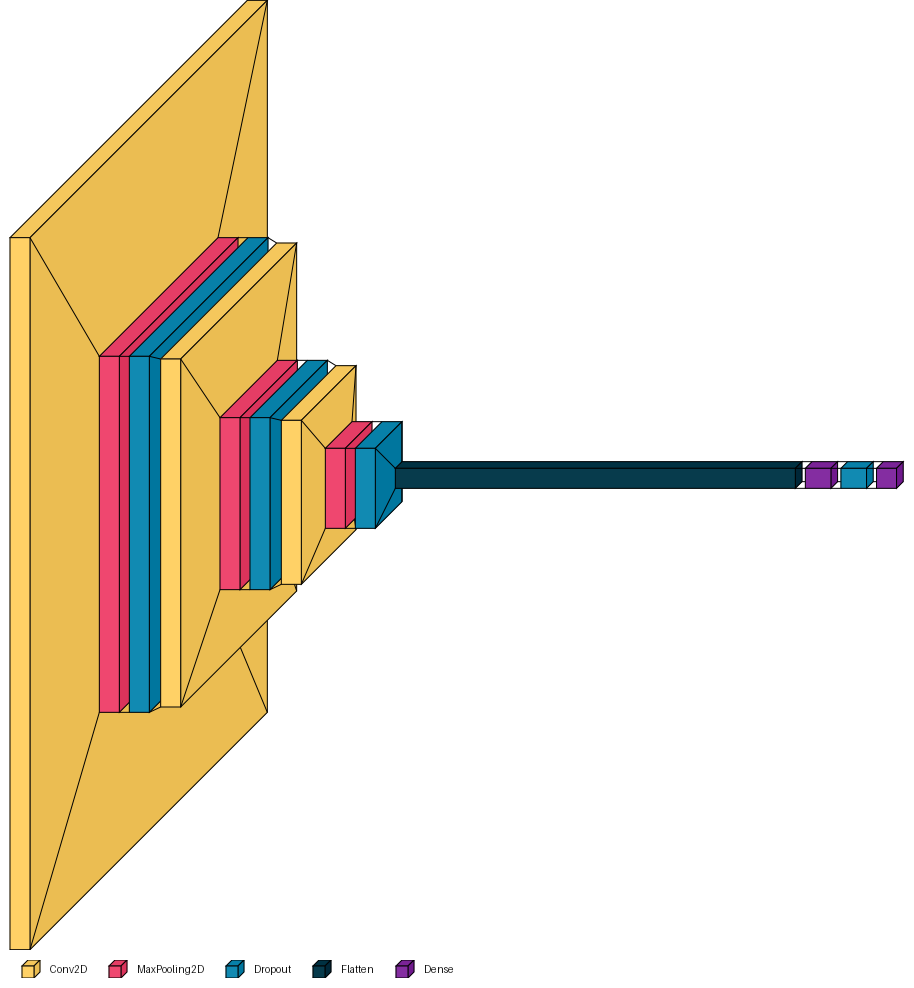

In [18]:
visualkeras.layered_view(model, legend=True)

### Entrainement

Nous pouvons finalement entraîner notre modèle.  
Nous définissons des `callbacks` :  
- Early stopping pour arrêter l’entraînement quand le modèle n’apprend plus (ou sur-apprend)
- Création de checkpoint pour sauvegarder notre modèle
- Nous avons défini les paramètres nécessaires : nombre d’epochs, dataset, callback, batch

#### Définition des callbacks

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./L1_model.keras', save_best_only=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#### Fit

In [20]:
epochs = 10

history = model.fit(train_set,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_set,
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint, tensorboard_callback])

Epoch 1/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 209s 162ms/step - accuracy: 0.3992 - loss: 2.5480 - val_accuracy: 0.5700 - val_loss: 0.4694
Epoch 2/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 206s 162ms/step - accuracy: 0.6140 - loss: 0.4372 - val_accuracy: 0.7206 - val_loss: 0.3099
Epoch 3/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 208s 164ms/step - accuracy: 0.7515 - loss: 0.2853 - val_accuracy: 0.7615 - val_loss: 0.2671
Epoch 4/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 217s 166ms/step - accuracy: 0.7999 - loss: 0.2191 - val_accuracy: 0.8082 - val_loss: 0.2003
Epoch 5/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 211s 166ms/step - accuracy: 0.8336 - loss: 0.1789 - val_accuracy: 0.8112 - val_loss: 0.2093
Epoch 6/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 211s 165ms/step - accuracy: 0.8460 - loss: 0.1662 - val_accuracy: 0.8282 - val_loss: 0.1922
Epoch 7/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 212s 164ms/step - accuracy: 0.8620 - loss: 0.1566 - val_accuracy: 0.8319 - val_loss: 0.1844
Epoch 8/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 211s 166ms/step - ac

## Courbe d’apprentissage

o Interprétation de la courbe :

- Surapprentissage : la situation de sur-apprentissage peut être détectée lorsque la courbe de loss de validation commence à augmenter par rapport à la loss d’entraînement qui est stabilisée. Pour lutter contre ce phénomène nous avons mis en place des couches de Dropout ainsi que la callback permettant le early-stopping. Ces actions préventives permette de d'arrêter l'entraînement avant de rentrer dans le cas échéant.

- Sous apprentissage : le modèle n’a pas encore extrait toutes les caractéristiques pertinentes des données. Les performances varient encore beaucoup d’une epoch à l’autre. Il convient d’ajouter des données ou des epochs pour améliorer les performances du modèle.Dans notre cas, nous n'avons pas eu ce problème car le dataset est correctement répartit avec une proportion de 80% de données d'entrainements pour 20% de données de validations sur un nombre total avoisinant les 45 000 données au total. 

- Validation vs training set : Comme évoqué ci-dessus, nous avons divisé notre jeu de données en 2 parties : une dédiée à l’entraînement de notre modèle, et l’autre dédiée à la validation de son apprentissage. Ainsi nous vérifions sa capacité de généralisation sur des nouvelles données.

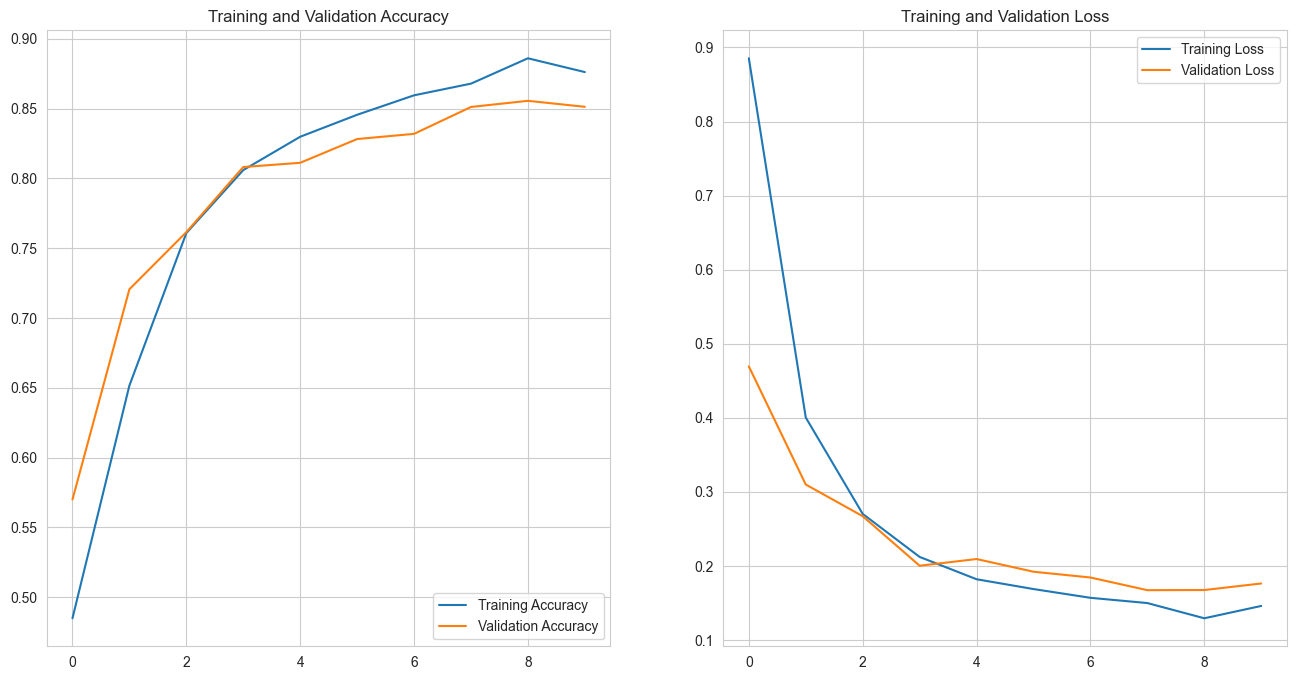

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model = load_model('L1_model.keras')

In [ ]:
%tensorboard --logdir logs/fit

## Métriques

### Matrice de confusion et rapport de classification

In [22]:
def confusion_matrix_and_report(model, val_set, class_names):
    print("Classes utilisées :", class_names)

    # Préparer les données de validation sans modification
    val_set = val_set.prefetch(buffer_size=tf.data.AUTOTUNE)

    # Obtenir les vraies étiquettes et les prédictions
    val_true_labels = []
    val_pred_labels = []

    for images, labels in val_set:
        # Prédictions pour le batch
        predictions = model.predict(images, verbose=0)
        val_pred_labels.extend(np.argmax(predictions, axis=1))
        val_true_labels.extend(labels.numpy())

    # Convertir en arrays numpy
    val_true_labels = np.array(val_true_labels)
    val_pred_labels = np.array(val_pred_labels)

    # Calculer la matrice de confusion
    conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

    # Afficher la matrice de confusion
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Matrice de Confusion")
    plt.xlabel("Classe Prédite")
    plt.ylabel("Classe Réelle")
    plt.show()

    # Afficher le rapport de classification
    report = classification_report(val_true_labels, val_pred_labels, target_names=class_names)
    print("Rapport de Classification :")
    print(report)

Classes utilisées : ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


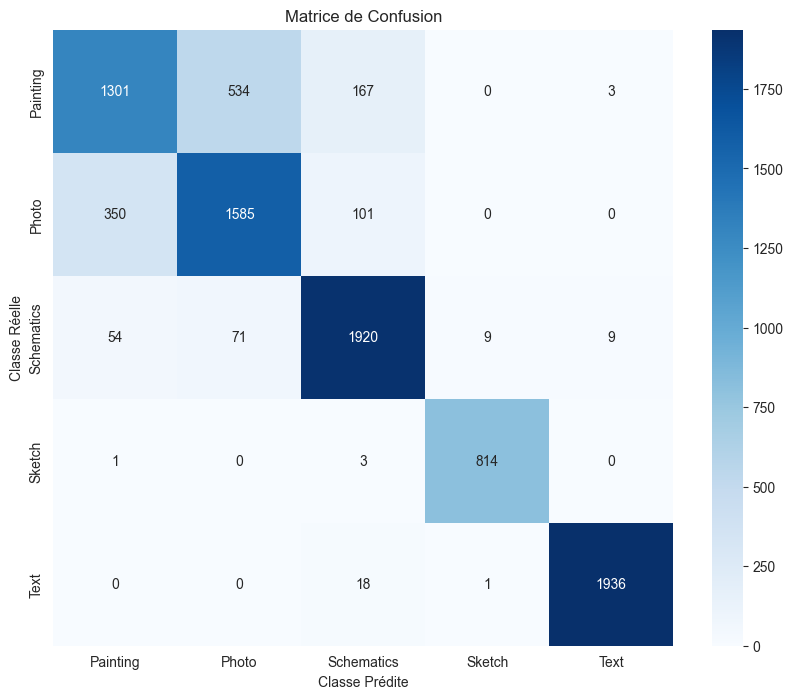

Rapport de Classification :
              precision    recall  f1-score   support

    Painting       0.76      0.65      0.70      2005
       Photo       0.72      0.78      0.75      2036
  Schematics       0.87      0.93      0.90      2063
      Sketch       0.99      1.00      0.99       818
        Text       0.99      0.99      0.99      1955

    accuracy                           0.85      8877
   macro avg       0.87      0.87      0.87      8877
weighted avg       0.85      0.85      0.85      8877



In [23]:
confusion_matrix_and_report(model, val_set, class_names)

## Matrice de confusion

La matrice de confusion permet de comparer la classe réelle et la classe prédite pour les données de validation envoyées au modèle. Cette matrice nous permet de mieux comprendre les erreurs de notre modèle afin de pouvoir s’adapter en conséquence. En l’occurrence, nous constatons que notre modèle a parfois du mal à distinguer les photos des peintures (qui peuvent avoir un rendu assez réaliste). Ainsi nous pouvons proposer des pistes d’amélioration telles que l’augmentation de la qualité de l’image entrante par exemple.

Precision, Recall, F1score : Ces métriques permettent de mieux analyser les performances du modèle, et donc de s’assurer qu’il n’y a pas trop de confusions entre les différentes classes.

### Résultats globaux
- **Accuracy** : **85%**
- **Macro Average** (moyenne non pondérée) :
  - Précision : **0.87**
  - Rappel : **0.87**
  - F1-score : **0.86**
- **Weighted Average** (pondérée par le nombre d'exemples) :
  - Précision : **0.85**
  - Rappel : **0.85**
  - F1-score : **0.84**
### Forces
- **Sketch** et **Text** sont très bien reconnus, avec des F1-scores proches de 1.
- **Schematics** présente un bon équilibre entre précision et rappel.
### Faiblesses
- **Photo** :
  - Faible rappel (**0.62**) → le modèle rate de nombreux vrais exemples de "Photo".
- **Painting** :
  - Faible précision (**0.70**) → le modèle confond "Painting" avec des "Photos" et des "Schematics".

### Tests de reconnaissance d'images

Essayons dès à présent notre modèle sur des images prises sur internet, pour nous rendre compte de son efficacité


--- Testing image for class 'Painting' ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Painting: 30.07%
Photo: 22.52%
Schematics: 15.81%
Sketch: 15.79%
Text: 15.79%

--- Testing image for class 'Photo' ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Painting: 21.57%
Photo: 30.84%
Schematics: 16.03%
Sketch: 15.78%
Text: 15.77%

--- Testing image for class 'Schematics' ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Painting: 15.87%
Photo: 15.87%
Schematics: 24.89%
Sketch: 27.50%
Text: 15.87%

--- Testing image for class 'Sketch' ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Painting: 22.29%
Photo: 19.38%
Schematics: 24.10%
Sketch: 17.35%
Text: 16.87%

--- Testing image for class 'Text' ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Painting: 14.88%
Photo: 14.88%
Schematics: 14.89%
Sketch: 40.46%
Text: 14.88%


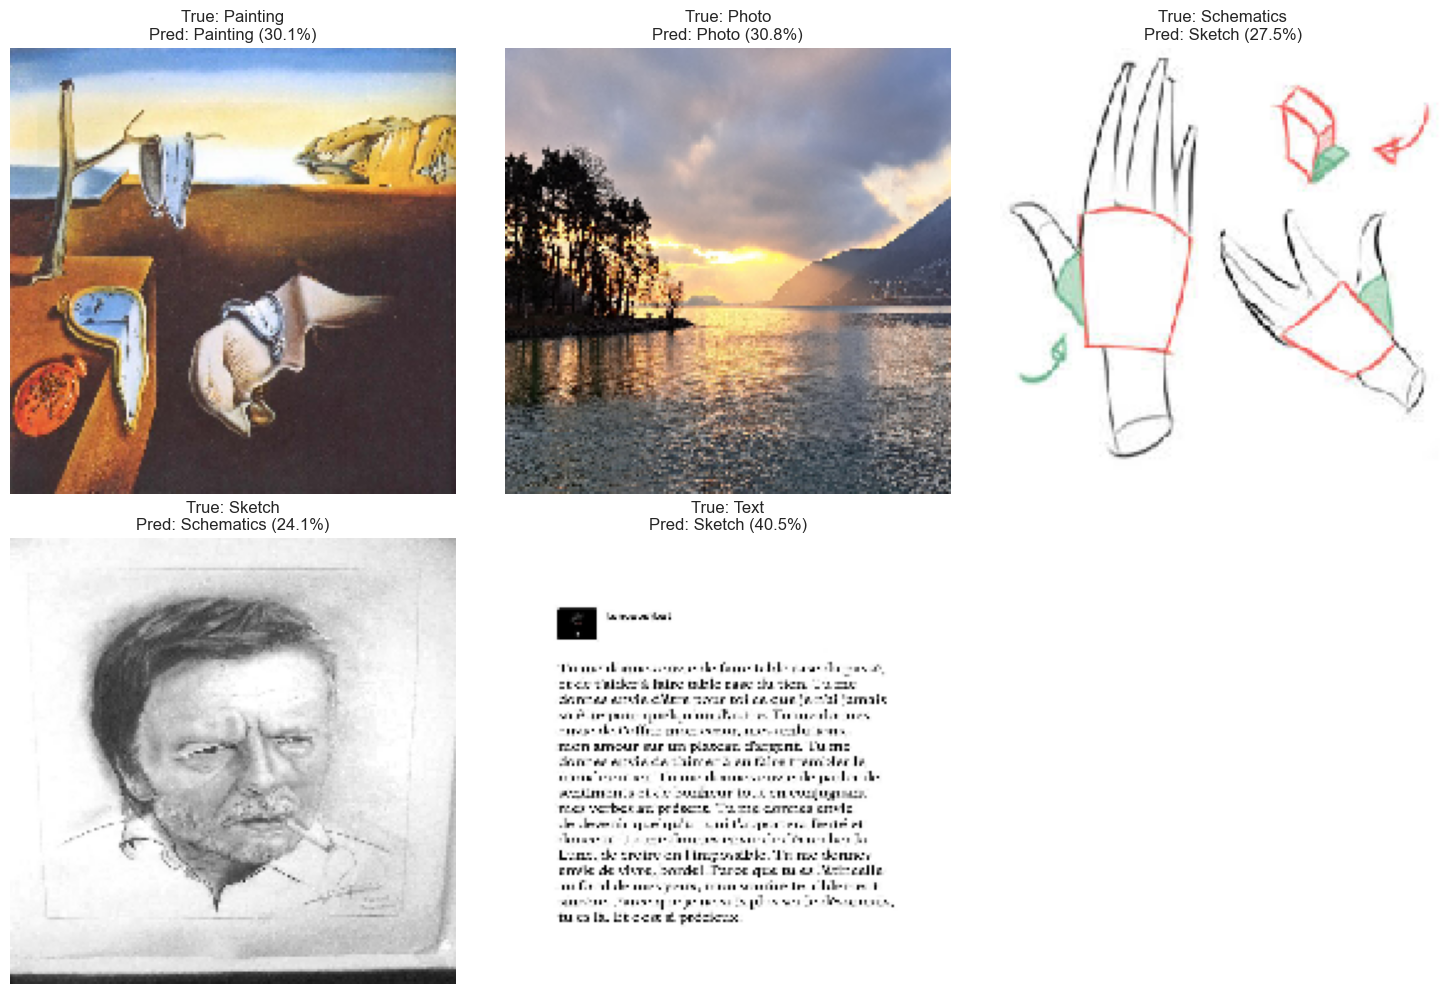

In [25]:
# Ton dico d'images
image_paths = {
    'Painting': 'data_validation/peinture.jpg',
    'Photo': 'data_validation/photo.jpg',
    'Schematics': 'data_validation/schema.jpg',
    'Sketch': 'data_validation/sketch.jpg',
    'Text': 'data_validation/text.jpg'
}

plt.figure(figsize=(15, 10))

img_index = 1
for label, path in image_paths.items():
    print(f"\n--- Testing image for class '{label}' ---")

    img = tf.keras.utils.load_img(path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Batch dimension

    predictions = model.predict(img_array)
    scores = tf.nn.softmax(predictions[0])

    predicted_label = class_names[np.argmax(scores)]
    confidence = 100 * np.max(scores)

    for i, score in enumerate(scores):
        print(f"{class_names[i]}: {100 * score:.2f}%")

    # Plot image dans le bon subplot
    plt.subplot(2, 3, img_index)
    plt.imshow(np.array(img).astype("uint8"))
    plt.axis("off")
    plt.title(f"True: {label}\nPred: {predicted_label} ({confidence:.1f}%)")

    img_index += 1  # incrémenter le compteur

plt.tight_layout()
plt.show()

On observe que notre modèle confond parfois les sketchs et les schémas, mais il est capable de reconnaître les peintures et les photos avec une grande précision.

## Benchmarking
Nous avons réalisé un benchmarking afin d’évaluer l’impact de différentes techniques d’optimisation et de régularisation sur les performances de notre modèle. Chaque méthode testée (data augmentation, rescaling, régularisation L1 & L2, suppression du dropout) a été analysée afin d’identifier les configurations les plus efficaces pour améliorer la robustesse et la généralisation du modèle.

### Ajout de data augmentation
L'application de la data augmentation, incluant des transformations comme la rotation et le zoom, a permis d'améliorer la robustesse du modèle sur des images variées. Cependant, bien que les résultats soient corrects, le modèle sans data augmentation a montré une meilleure performance globale.  
![alt text](./img/data_augmentation_learning_curve.png)

### Rescaling
Le rescaling des données a conduit à une amélioration significative de la précision d'entraînement et de validation, atteignant des valeurs proches de 0.95. La perte a également diminué de manière constante, indiquant une bonne convergence du modèle. Cette technique semble efficace pour améliorer la performance du modèle.  
![alt text](./img/rescaling_learning_curve.png)

### Sans dropout
L'absence de dropout entre les couches de convolution a montré une augmentation de la précision d'entraînement et de validation, mais avec une légère divergence entre les deux courbes, suggérant un potentiel surapprentissage. La perte a diminué, mais la validation reste plus élevée, indiquant que le modèle pourrait bénéficier de techniques de régularisation.  
![alt text](./img/without_dropout_learning_curve.png)

### Ajout de la régularisation L1 & L2
L'ajout de la régularisation L1 et L2 a aidé à stabiliser le modèle, réduisant le risque de surapprentissage. Les courbes de précision et de perte montrent une amélioration dans la généralisation du modèle, avec une performance plus équilibrée entre les données d'entraînement et de validation. 
![alt text](./img/regularization_learning_curve.png)

## Conclusion

Pour conclure, ce premier livrable nous a permis de concevoir un modèle prédictif multiclasses performant.  
Nous avons pris en main les données de notre dataset, que nous avons analysées afin d'en faciliter l'exploitation. Un pré-traitement a été réalisé sur nos images afin de supprimer les données inappropriées et d'optimiser la qualité des entrées.  
Nous avons ensuite défini une architecture optimale pour notre classifieur, puis entraîné notre modèle sur les données traitées. L’analyse des performances, à l’aide de différentes métriques, nous a permis d’évaluer la qualité de notre modèle.  
Enfin, un benchmark a été réalisé afin de sélectionner la meilleure version de notre modèle.  
Nous sommes désormais prêts à aborder la deuxième partie de ce projet, qui consistera notamment à implémenter un autoencodeur afin de débruiter nos données.  
Nous poursuivrons également l’amélioration de notre modèle actuel, notamment pour le rendre plus robuste afin de mieux différencier les images des peintures.  
Nous envisagerons l’intégration d’autoencodeurs et/ou de techniques de transfert learning pour y parvenir.